# **Titanic Survivor Classification**

## **Overview**

Setting sail from Southampton on 10th April 1912, the RMS Titanic and its perilous demise has been so mythologised in popular culture - invoking Hollywood pageantry more than the 1,500 lives lost - that its true human tragedy remains unexplored.

This Notebook represents my very first data science project, within which I will tackle problems fundamental to the discipline, such as cleaning missing data, visualising univariate distributions, examining bivariate relationships, engineering new features, and comparing the predictive powers of three unique machine learning models - logistic regression, random forest classification, and gradient boosted classification.

Through this layered analysis, I hope to uncover the hidden patterns and determine which factors truly shaped survival outcomes from this tragic event.

## **Environment & Library Setup**

To begin this project, I have opened **Jupyter Notebooks** through my device's terminal, where it sits with the **Titanic** dataset - titled **Titanic-Dataset.csv**. This ensures that the work will remain stored in a place which is repeatable and easy to find. Following this, the key third party libraries are installed. Specifically, **pandas** is imported for data manipulation, **NumPy** for numerical operations, and **matplotlib** and **seaborn** which are used for data visualisation. Separately, I have imported all the needed tools from **sklearn's** library which will help with the modeling process towards the end of the project. Finally, I set **Seaborn's** default theme throughout the notebook to allow for smooth integration within the **matplotlib** figures.

In [1]:
# Jupyter setup commands
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import sklearn tools for later usage
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, ConfusionMatrixDisplay, classification_report

In [4]:
# Applying Seaborn's default theme within the notebook
sns.set()

## **Loading the Dataset**

Now that the environment has been setup, it is time to load the dataset for this project, **'Titanic-Dataset.csv**. We store it to a variable, **'data'**, and inspect it at a surface level.

In [5]:
# Assign our titanic dataset to the variable 'data'
data = pd.read_csv('Titanic-Dataset.csv')

In [6]:
# View the features that define our dataset, identifying our target feature of 'Survived'
data.keys()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
# Provide a view of whether we have any null entries, and for the data types within the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


This brief analysis has revealed that we must clean our dataset before moving on with the project. Firstly, there are null entries in several columns, those being **'Age'**, **'Embarked'** and most notably **'Cabin'**, which has only **204** valid entries. Further, we have witnessed that we have features of type **object**, most importantly **'Sex'**. We must convert this feature to have numerical values before beginning with the modeling.

## **Cleaning and Preparing the Data**

Within this stage of the project, we first clean the dataset of any aforementioned **null entries**. For the largest offender, **'Cabin'** we must introduce a new feature named **'Has Cabin'**, which following some label encoding will assign **1** for those with a cabin, and **0** for those without. Next, we create a new feature **'Deck'**, which assigns the respective deck to each of those with cabins, and a value 'Unknown' to those without. Following this, we tackle the features **'Age'** and **'Embarked'**, for which we replace the missing values for the **median** and **mode**.

In [9]:
# Introduce category of 'Has Cabin'
data['Has Cabin'] = data['Cabin'].notnull().astype(int)

# Create a feature 'Deck', setting blank values to 'unknown'
data['Deck'] = data['Cabin'].str[0]
data['Deck'] = data['Deck'].fillna('Unknown')

# Create a tabular display of the newly appended columns
data[['Cabin', 'Has Cabin', 'Deck']].head(5)

,Cabin,Has Cabin,Deck
0,NaN,0,Unknown
1,C85,1,C
2,NaN,0,Unknown
3,C123,1,C
4,NaN,0,Unknown


In [10]:
# Replace missing ages with median
age_median = data['Age'].median()
data['Age'] = data['Age'].fillna(age_median)

# Confirm that there are no null entries in 'Age'
data['Age'].isnull().sum()

np.int64(0)

In [11]:
# Replace missing embarkation entries with mode
embark_mode = data['Embarked'].mode()[0]
data['Embarked'] = data['Embarked'].fillna(embark_mode)

# Confirm that there are no null entries in 'Embarked'
data['Embarked'].isnull().sum()

np.int64(0)

In [12]:
# Check again for missing values
missing_count = pd.DataFrame({'missing_count': data.isnull().sum()})
missing_count.T   

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has Cabin,Deck
missing_count,0,0,0,0,0,0,0,0,0,0,687,0,0,0


This stage of the project has successfully cleaned the dataset, perfectly illustrated by the table shown above. In this table, each of our relevant features have missing counts of **0**. The only feature with missing values is **'Cabin'**, however from our feature engineering we have replaced this with a binary classification of **'Has Cabin'**, bypassing the potential issue.

## **Univariate Feature Analysis**

Within this section, we will **viualise** the **distributions** of each of our features and try to identify any **patterns** or **trends** that will be useful for our modeling later on. To begin, we create **histograms** for the two **continuous** features in the dataset, **'Age'** and **'Fare'**. Following this, we create **countplots** for both our **discrete** and **binary** factors, showing us the distributions of **'Pclass'**, **'Sex'**, **'Embarked'**, and **'Has Cabin'**. This simple analysis allows us to gauge the distributions of our features and begin to make predictions for our modeling.  

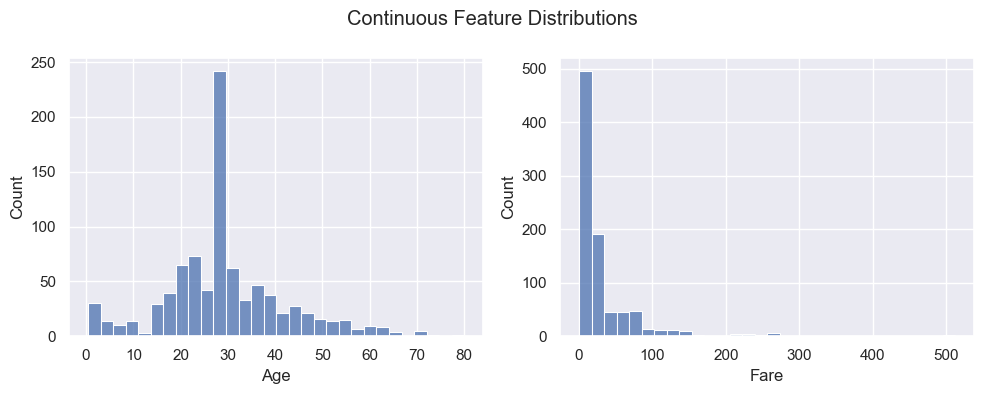

In [13]:
# Create a grid for the continuous feature plots
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes = axes.flatten()

# Plots for age and fare distributions
sns.histplot(data=data, x='Age', bins=30, ax=axes[0]) 
sns.histplot(data=data, x='Fare', bins=30, ax=axes[1])  

# Create a title and formatting for the plots
plt.suptitle('Continuous Feature Distributions')
plt.tight_layout()
plt.show()

These two plots above show the distributions of both **'Age'** and **'Fare'**. Starting with age, we see a large spike in quantity at around **28-29**, with most other passengers also within 10 years either side of that peak. Though most passengers are therefore between the ages of **20-40**, we have some interesting tails on either end of the data. Firstly, there is a spike in the count of **children under 10**, suggesting that some passengers have boarded as families. Also, we observe a **right-skew** in the dataset, showing that some of the passengers are elderly, the oldest of which being **71**. Moving onto **'Fare'**, more valuable trends emerge. We firstly witness that the average fare is between **£10-£30**, with a huge count of almost **500** passengers paying only around **£10** for their tickets. As with age, the feature **'Fare'** is also heavily **right-skewed**, with a handful of passengers paying upwards of **£200** for their tickets. 

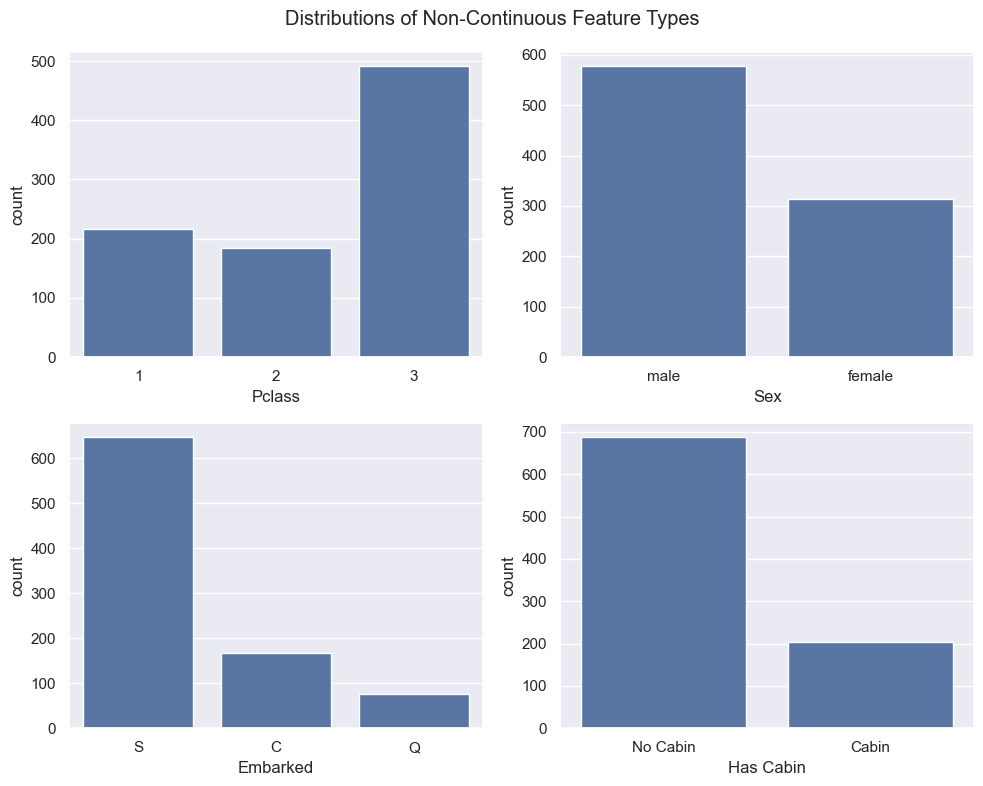

In [14]:
# Create a grid for the discrete and binary feature plots
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.flatten()

# Make the individual graphs to fill the grid 
sns.countplot(data=data, x='Pclass', ax=axes[0])
sns.countplot(data=data, x='Sex', ax=axes[1])   
sns.countplot(data=data, x='Embarked', ax=axes[2])
sns.countplot(data=data, x='Has Cabin', ax=axes[3])
plt.xticks([0, 1], ['No Cabin', 'Cabin'])

# Write a title and sort the formatting for the graphs
plt.suptitle('Distributions of Non-Continuous Feature Types')
plt.tight_layout()
plt.show()

Above are the ditributions of our **4 discrete** and **binary** features from the dataset, each of which provide valuable insight we can carry forward throughout the project. Firstly, we observe that the **'Plass'** feature has **3** options, with the majority of passengers categorised as **3rd Class** - which aligns with the feature **'Fare'** having a high concentration of low-cost tickets. Moving on, the distribution of the feature **'Sex'** reveals that there were arounf **250** more male passengers than there were female, perhaps a reminder that this dataset is taken from 1912. Next, the feature **'Embarked'** tells us where our passengers boarded the voyage. From this, we can see that the majority of passengers, around **650**, boarded at **Southampton**, with another **170** at **Cherbourg** and finally around **80** boarding at **Queenstown**. Finally, the distribution of our manufactured feature **'Has Cabin'** confirms what we already knew, that most passengers' **'Cabin'** entries were empty.

From this **univariate analysis** we have observed the **distributions** of each of our features. We have witnessed similar trends for overlapping features, for instance **'Fare'**, **'Pclass'** and **'Has Cabin'** all show that the majority of passengers did not have access to all amenities and were likely working class. Given this knowledge, and some assumptions about society in 1912, we can make the prediction that those categorised as such will have **lower chances of survival**. However, before making any large claims like this, we must confirm our assumptions through a **bivariate feature analysis**, which depicts the relationship between each feature type and rate of survival. 

## **Bivariate Feature Analysis**

Following the **univariate feature analysis** of the previous section, we will now begin to plot how our features interact with one another, and ultimately how they relate to our target variable, the **rate of survival**. We begin this section with a **correlation matrix**, which plots the correlations between each of our factors. Though for our modeling we ultimately care about the correlation between our **target** and **non-target** features, the correlation matrix also allows us to see how our **non-target** features interact, providing additional insight and allowing us to extrapolate further. Next, we plot the **survival rates** for each of our features, beginning with **bar graphs** of both the **discrete** and **binary** features before moving onto creating **boxplots** that show the **survival rates** for our **continous features**. To conclude the section, we create a **pairplot** which shows the features **'Age'**, **'Fare'** and **'Pclass'**. By setting the colour of the points within the scatterplots to our **target variable**, we see how our non-target features interact, and ultimately the result of these interations on a passenger's **survival chances**.

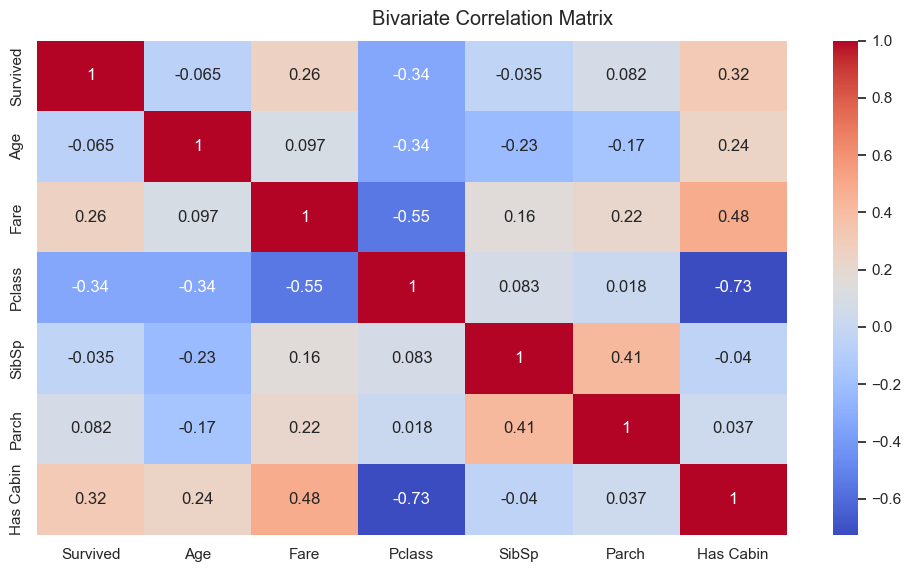

In [15]:
# Create the correlation matrix, first defining the numeric features
numeric_features = ['Survived', 'Age', 'Fare', 'Pclass', 'SibSp', 'Parch', 'Has Cabin']
corr = data[numeric_features].corr()

# Transform the correlation matrix into a heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Create a title and formatting for the matrix
plt.suptitle('Bivariate Correlation Matrix', y=0.95)
plt.tight_layout()
plt.show()

The **correlation matrix** above reveals some key characteristics about the numerical features within the dataset. The column and row we are most focused on are the first of each, for the feature **Survived'**. Looking here, we witness that the features that are the strongest predictors for the target are **'Fare' (0.26)**, **'Has Cabin' (0.32)**, and **'Pclass' (-0.34)**. Where both **'Fare'** and **'Has Cabin'** are positively correlated, meaning that higher values imply higher chances of survival, the feature **'Pclass'** is negatively correlated, which intead suggests that the rate of survival increased as the class of the passenger decreased. This can be seen to support our **hypothesis** made in the previous section, suggesting that the **working class** majority of passengers had lower rates of survival than their richer peers. The remaining features, **'Parch'**, **'SibSp'**, and '**Age'** all have correlation scores of magnitude **less than 0.1**, suggesting that they will be less significant as predictors for **'Survived'**. Moving elsewhere, other observations we can make from the correlation matrix include **'Pclass'** and **'Has Cabin'** having high correlation with many of the non-target features, and that although **'Age'** is highly correlated with good predictive features for our target variable, **'Pclass (-.034)**, **Has Cabin (0.24)**, it itself is relatively uncorrelated with chances of survival, with only a **-0.065** correlation to the target feature.

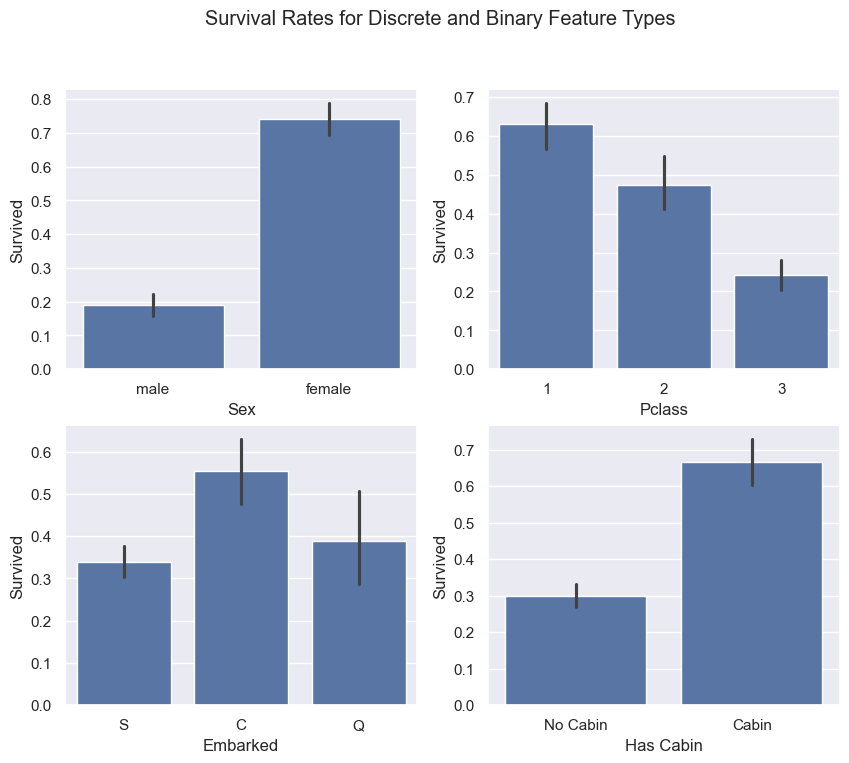

In [16]:
# Create a grid for the 4 plots
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.flatten()

# Create each barplot within the grid
sns.barplot(x='Sex', y='Survived', data=data, ax=axes[0])   
sns.barplot(x='Pclass', y='Survived', data=data, ax=axes[1]) 
sns.barplot(x='Embarked', y='Survived', data=data, ax=axes[2]) 
sns.barplot(x='Has Cabin', y='Survived', data=data, ax=axes[3])
plt.xticks([0, 1], ['No Cabin', 'Cabin'])

# Create a title and formatting for the graphs
plt.suptitle('Survival Rates for Discrete and Binary Feature Types')
plt.tight_layout
plt.show()

The 4 graphs above show the **survival rates** for the discrete features within the dataset. Beginning with the feature **'Sex'**, we can observe a **huge** discrepancy of around **55%** between the survival rates of males at just **20%**, and females at around **75%**, proving that chivalry in 1912 was as strong as ever, and suggesting that the feature will be a good predictor for our target variable. Next, when looking at the feature **'Pclass'**, our earlier hypothesis and observations within the **correlation matrix** are confirmed, with a huge discrepancy ranging from a survival rate of over **60%** for first class passengers, to just **25%** for passengers in third class. The graph in the bottom left shows the survival rates based upon **embarkation**. In this, we witness that passengers who boarded from **Cherbourg** had the highest chance of survival, **55%**, and that the majority who embarked from **Southampton** survived only **35%** of the time. Though perhaps less telling than with other features, we could predict that passengers who embarked from **Cherbourg** may have been disproportionately represented in **first class tickets**, or that they were assigned to **decks** that had higher chances of survival. Finally, the graph representing the **'Has Cabin'** feature reveals that those with cabins survived over **30%** more often than those without. 

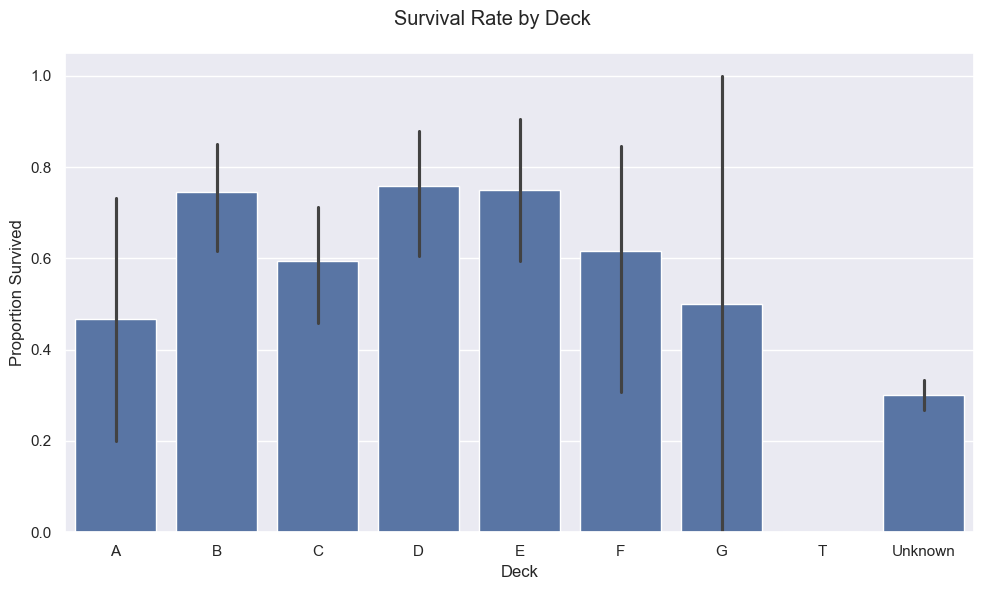

In [17]:
# Create a figure which plots survival Rate by Deck
plt.figure(figsize=(10,6))
sns.barplot(x='Deck', y='Survived', data=data, order=sorted(data['Deck'].unique()))
plt.ylabel ('Proportion Survived')

# Create a title and formatting for the graph
plt.suptitle('Survival Rate by Deck')
plt.tight_layout()
plt.show() 

The figure above shows the **survival rate** by **passenger deck**. Here we again witness large discrepancies, with **Deck D** having the highest rate of survival at **75%**, and the unfortunate passengers of **Deck T** surviving **0%** of the time. It is also evident that the majority of passengers whose decks were **Unknown** had a markedly lower chance of survival at only **30%**, which makes sense given our previous findings that passengers with **lower fares** and **no cabins** had much lower survival rates than their peers.

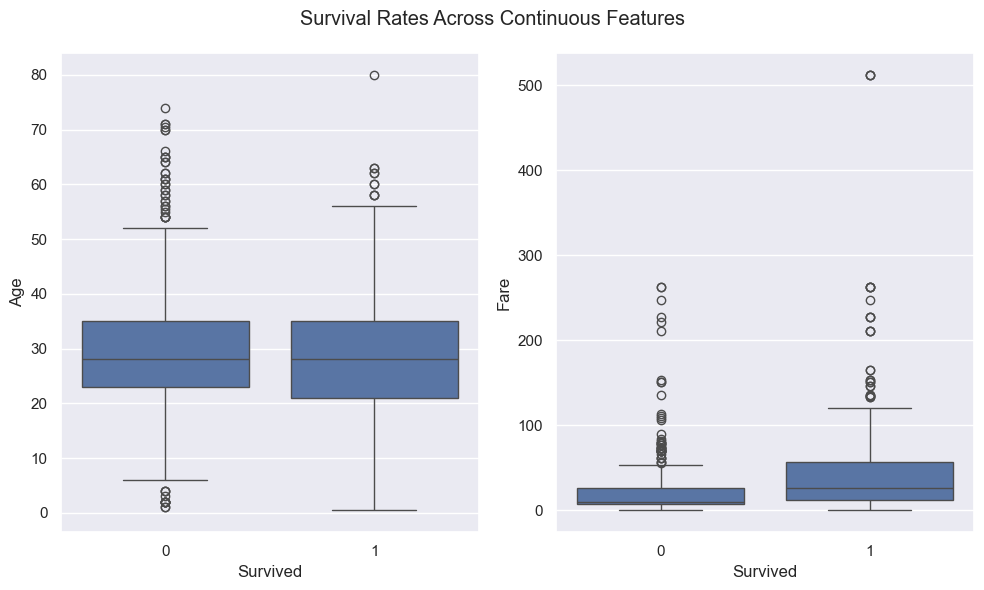

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
axes = axes.flatten()


sns.boxplot(x='Survived', y='Age', data=data, ax=axes[0]) # Larger spread of ages for non-survivors.
sns.boxplot(x='Survived', y='Fare', data=data, ax=axes[1]) # Passengers with greater fares were more likely to survive.

plt.suptitle('Survival Rates Across Continuous Features')
plt.tight_layout()
plt.show()

The pair of **boxplots** above represent the **survival rates** for our continuous features **'Age'** and **'Fare**. With regards to **age**, we see similar **medians** and **interquartile ranges** for both survivors and non survivors. However, the spread of ages for survivors is definitely higher, indicating that **children** and the **elderly** were likely prioritised. Despite the smaller spread for non-survivors, we observe a greater amount of **outliers**, such as the children under 5 and elderly over 55, indicating that this rule didn't hold true 100% of the time. With regard to the feature **'Fare'**, there is a noticable difference between the boxplots. Firstly, our earlier findings that higher paying passengers survived more often is clear to see, with the media fare of survivors being around **£20**, compared to around just **5%** for those that died. Also, the spread is much larger for survivors, indicating again that those paying the highest amount had better chances of survival. 

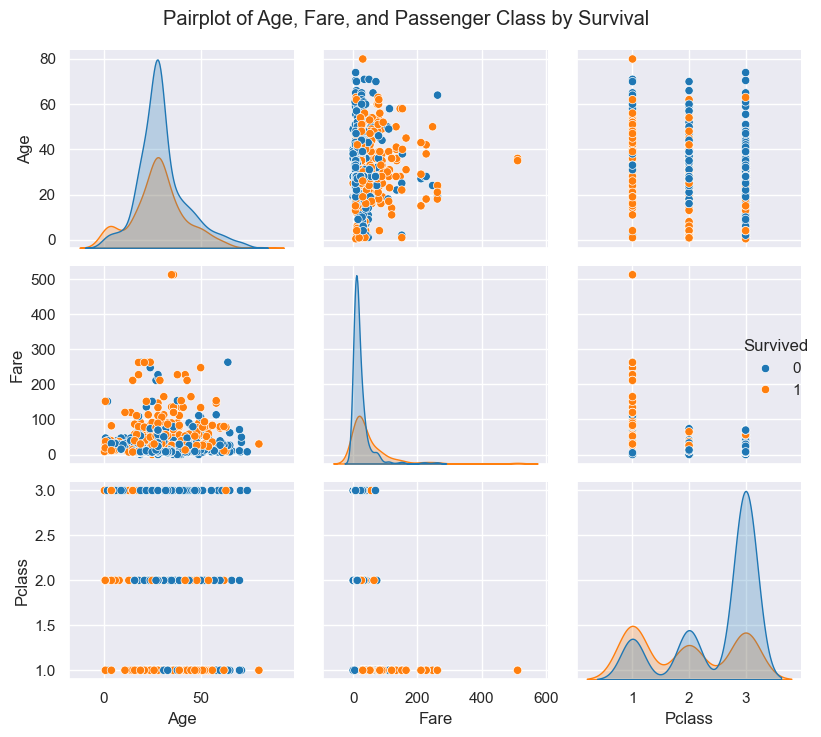

In [19]:
# Create a pairwise scatter plot with the target variable distinguishable by colour
sns.pairplot(data, vars=['Age', 'Fare', 'Pclass'], hue='Survived', palette='tab10', diag_kind='kde')

# Formatting and writing a title for the plot
plt.suptitle('Pairplot of Age, Fare, and Passenger Class by Survival')
plt.tight_layout()
plt.show()

The **pairwise scatter** shown above allows for us to directly compare our non-target features, and observe how their interrelations ultimately impacted the target. For the feature **'Age'**, we can see that both **fares** and **ticket classes** are relatively evenly distributed, and that there are no obvious trends between the pairwise relationships and **chances of survival**. The combination of the features **'Fare'** and **'Pclass'** is slightly more revealing though, showing that the combination of **high ticket price** and **first class tickets** essentially guaranteed survival, and that those with **low ticket prices** in **third class** hardly survived at all.

Overall, the **bivariate feature analysis** that we have just completed has provided truly valuable insight into the properties of our dataset, and the relationship that each feature has with the target variable. We have identified the features with the strongest predictive powers, namely **'Pclass'**, **'Has Cabin'**, and **'Sex'**. From this we were able to extrapolate two key arguments. Firstly, we have proven that **money**, being represented by proxy through the features **'Pclass'**, **'Fare'**, and **'Has Cabin'** was the single largest determinant for one's survival, reflecting our prefound knowledge of societal inequality in the early 1910s. Secondly, the next largest predictor can be seen as **'Sex'**, with women much more likely to survive than their male counterparts. Further, though the feature **'Age'** had a fairly low correlation with survival rates, we saw that children had higher chances of survival. In combination, the higher survival rates of women and children confirm the age-old notion of 'women and children first', reminding us of the chivalry of the time.

## **Feature Engineering**

Now we will embark in some **feature engineering**, extrapolating new features from the categorisations already defined within our dataset in the hopes of uncovering some hidden trends. The first feature introduced is **'Family Size'**, calculated by combining the **'SibSp'** (siblings/spouse) and **'Parch'** (parents and children), then adding 1, which will allow us to see the benefits and costs of traveling in different party sizes on survival chances. From this, we introduce the binary category of **'Is Alone'**, to see if traveling solo had any ramifications on chances of survivial. Next, we create the feature **'Fare Per Person'**, which divides the feature **'Fare'** by our newly engineered feature **'Family Size'** and allows us to see impact that costs of individual tickets had on chances of survival. The final created feature is **'Title'**, which identifies a person's title from their name, giving us a greater understanding of each passenger's social standing. Importantly, for the titles that were particularly uncommon, such as Jonkheer, we create a bundle named **'Rare'**, allowing us to avoid sparse matrices when later using the **OneHotEncoder** tool to numericise our categorical values. Lastly, we plot our newly created features as we did our others, and observe for any trends that may become relevant when modeling the data.

In [20]:
# Save a copy of our cleaned dataset for any future investigations
data.to_csv('Cleaned-Titanic-Dataset.csv', index=False)

In [21]:
# Create Family Size feature (SibSp + Parch + 1)
data['Family Size'] = data['SibSp'] + data['Parch'] + 1

# Create Is Alone feature (1 if Yes, 0 if No)
data['Is Alone'] = (data['Family Size'] == 1).astype(int)

# Create Fare Per Person feature (Fare / FamilySize)
data['Fare Per Person'] = (data['Fare'] / data['Family Size']).round(2)

# Display a table showing the first 15 entries for our engineered features
data[['Family Size', 'Is Alone', 'Fare Per Person']].head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Family Size,2.00,2.00,1.00,2.00,1.00,1.00,1.00,5.00,3.00,2.00,3.00,1.00,1.00,7.00,1.00
Is Alone,0.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00
Fare Per Person,3.62,35.64,7.92,26.55,8.05,8.46,51.86,4.22,3.71,15.04,5.57,26.55,8.05,4.47,7.85


In [22]:
# Create a feature for passenger's titles
data['Title'] = data['Name'].str.extract(r',\s*([^\.]+)\.')

# Distinguish irregular titles as 'Rare'
rare_titles = ['Lady', 'the Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Mlle', 'Mme', 'Ms']
data['Title'] = data['Title'].replace(rare_titles, 'Rare')

# Display the counts of our newly engineered titles
data['Title'].value_counts()

Title
Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: count, dtype: int64

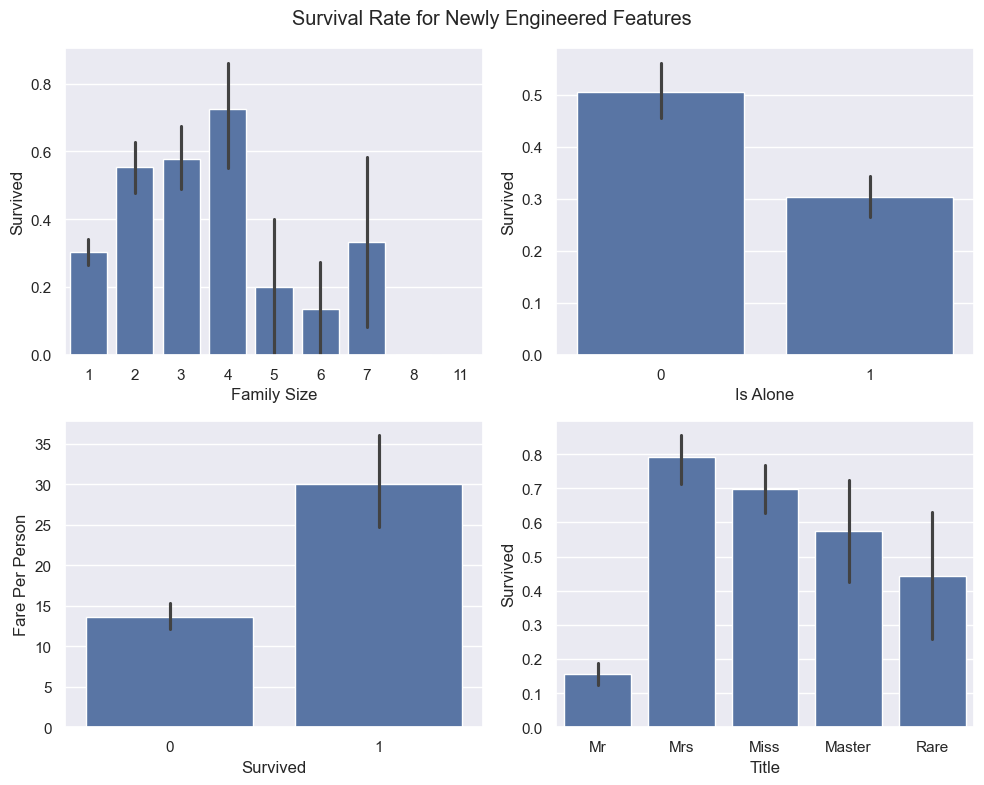

In [23]:
# Create a grid for the plots showing the relationships between the new features and survival rate
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.flatten()

# Create the graphs for each new feature
sns.barplot(x='Family Size', y='Survived', data=data, ax=axes[0])
sns.barplot(x='Is Alone', y='Survived' , data=data, ax=axes[1])    
sns.barplot(x='Survived', y='Fare Per Person', data=data, ax=axes[2])   
sns.barplot(x='Title', y='Survived', data=data, ax=axes[3])     

# Create a title and program formatting for graph grid
plt.suptitle('Survival Rate for Newly Engineered Features')
plt.tight_layout()
plt.show()

The plots above represent the relationship of each of the newly created features with the target variable, and certainly confirms the trends that we have already observed. To begin, the graph showing **'Family Size'** reveals that the highest chances of survival occur in parties of **4** with **70%**, closely followed by **3** and **2** with survival rates of around **55%** each. This shows that having some form of assistance in the disaster was crucial, with those alone surviving only **30%** of the time (supported by the next graph in the top-right), but that having to account for a party too large, such as **8** or **11** (both of which scoring 0 survivors), was detrimental to hopes of survival. The graph for the feature **'Fare Per Person'** is also telling, where the discrepancy between those that survived and didn't is much less pronounced than the **'Fare'** feature suggested, which potentially contradicts our hypothesis that **money**, through the form of many proxy features, was the largest determinant for suvival chances. Lastly, the graph depicting the feature **'Title'** is perhaps the most interesting, with the chivalrous trends observed earlier clear to see. Married women, or those with the title **Mrs** had the highest chances of survival **(80%)**, whilst adult men, or those with the title **Mr** had the lowest chance **(15%)**. We also notice that young men, those with the title **Master** had markedly higher survival rates than their older peers **(58%)**, although there chances were still much lower than unmarried women **(70%)**.

## **Data Scaling & Splitting**

The final step before modeling the data will be to **scale**, **split**, and **preprocess** our data. In our earlier analysis, we noticed that both of our continuous features, **'Age'** and **'Fare'** were heavily right-skewed. This shows that each feature contains outliers, which if left unaddressed can confuse our model and lead to it failing to converge to a solution. Therefore, we will **scale** both by taking the **log** of each, which will reduce variance and increase our model's predictive powers. Secondly, we must ensure that we **split** the dataset before modeling. This is so that there is no contamination of the model, meaning that it doesn't see any of the **testing** entries during the entire **training** process, which would invalidate our model's performance. To do this, we use **sklearn's train_test_split** tool, which randomly shuffles our data before splitting it into **training** and **testing** sets. The final step before modeling is to build a preprocessing transformer which applies **OneHotCoding** to our **categorical features**, which will allow us to use all of our features within the modeling processes.

In [24]:
# Save a copy of our final engineered and cleaned dataset for any future investigations
data.to_csv('Features-Titanic-Dataset.csv', index=False)

In [25]:
# Amend the skew in both continuous graphs for better modeling
data['Age'] = np.log1p(data['Age'])
data['Fare'] = np.log1p(data['Fare'])

In [26]:
# Remind ourselves of our features before splitting
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      891 non-null    int64  
 1   Survived         891 non-null    int64  
 2   Pclass           891 non-null    int64  
 3   Name             891 non-null    object 
 4   Sex              891 non-null    object 
 5   Age              891 non-null    float64
 6   SibSp            891 non-null    int64  
 7   Parch            891 non-null    int64  
 8   Ticket           891 non-null    object 
 9   Fare             891 non-null    float64
 10  Cabin            204 non-null    object 
 11  Embarked         891 non-null    object 
 12  Has Cabin        891 non-null    int64  
 13  Deck             891 non-null    object 
 14  Family Size      891 non-null    int64  
 15  Is Alone         891 non-null    int64  
 16  Fare Per Person  891 non-null    float64
 17  Title           

In [27]:
# Define the features (X) and target (y)
X = data[['Pclass', 'Sex', 'Age', 'Fare Per Person', 'Family Size', 'Is Alone', 'Title', 'Has Cabin']]
y = data['Survived']

In [28]:
# Use sklearn's train_test_split model to separate our training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of our subsets to check our DataFrames are of the correct size
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(712, 8) (179, 8) (712,) (179,)


In [29]:
# Specify categorical & numerical columns
cat_features = ['Sex', 'Title', 'Has Cabin', 'Is Alone']
num_features = ['Pclass', 'Age', 'Fare Per Person', 'Family Size']

In [30]:
# Build a preproccessing transformer
preprocessor = ColumnTransformer([('Numerical', 'passthrough', num_features), ('Categorical', OneHotEncoder(), cat_features)])

## **Logistic Regression Model**

We have now completed all of our prerequisite steps, and can begin with the modeling processes. The first model will be a **logistic regression**, which is a simple model that takes a linear regression then applies a **sigmoid** function to our outputs, transforming each into a probability between **0** and **1**. This output represents the model's confidence of a positive incident, in this case it's the model's confidence that a passenger survived. If the output is greater than 0.5, the model will assign the passenger as **survived**, and if it is less than **0.5** it will assign them as a non-survivor. 

The **hyperparameters** we are tuning for this model are **penalty**, which defines the metric we optimise for through the gradient descent process, **C**, which defines the strength of regularisation and defines how tightly we want our model to fit the training data, and **max_iter**, which defines the maximum number of iterations we allow for the model before converging. To maximise our confidence in our results, we have used **sklearn's** **GridSearchCV** tool, which allows us to **crossvalidate** the model on **5** splits of the training data, and rank our hyperparameter options, using **f1** score, an average of the **precision** and **recall** scores outlined below.

Now the model is trained, we score it on the witheld test set to grade it's performance on unseen data. We first assign our model it's optimal parameters, found through the training process, and have it estimate the target variable for each X_test entry. We also make note of the model's confidence for each decision, or how close the sigmoid function's outputs were to 1 or 0, for positive and negative assignments respectively. Finally, we print and examine the results, analysing metrics such as **accuracy**, **ROC AUC**, **precision**, and **recall**.

In [31]:
# Define our logistic regression model
log_reg = LogisticRegression()  

In [32]:
# Define a hyperparameter grid we can use to optimise the model
lr_param_grid = {'Clas__penalty': ['l1', 'l2'], 'Clas__C': [1, 1.125, 1.25], 'Clas__solver': ['liblinear'], 'Clas__max_iter': [48, 50, 52]}

In [33]:
# Create a modelling pipeline
lr_pipeline = Pipeline([('Prep', preprocessor), ('Clas', log_reg)])

In [34]:
# Tune our hyperparameters using GridSearchCV
lr_model = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, scoring='f1')

In [35]:
# Train the model
lr_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Prep',
                                        ColumnTransformer(transformers=[('Numerical',
                                                                         'passthrough',
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'Fare '
                                                                          'Per '
                                                                          'Person',
                                                                          'Family '
                                                                          'Size']),
                                                                        ('Categorical',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'Title',
                                                                          'Has '
                                                                          'Cabin',
                                                                          'Is '
                                                                          'Alone'])])),
                                       ('Clas', LogisticRegression())]),
             param_grid={'Clas__C': [1, 1.125, 1.25],
                         'Clas__max_iter': [48, 50, 52],
                         'Clas__penalty': ['l1', 'l2'],
                         'Clas__solver': ['liblinear']},
             scoring='f1')

In [36]:
# Optimal parameters to maximise model performance
print('Optimal Hyperparameters: ', lr_model.best_params_)

Optimal Hyperparameters:  {'Clas__C': 1.125, 'Clas__max_iter': 48, 'Clas__penalty': 'l1', 'Clas__solver': 'liblinear'}


In [37]:
# Assign our optimal hyperparameters to the model before testing
best_lr_model = lr_model.best_estimator_

In [38]:
# Model predictions for the test set
lr_predictions = best_lr_model.predict(X_test)

In [39]:
# Create a metric measuring the model's confidence scores for each person's survival
lr_proba = best_lr_model.predict_proba(X_test)[:,1]

In [86]:
# Performance evaluation
print('Performance for Logistic Regression Model')
print(f'Accuracy: {accuracy_score(y_test, lr_predictions):.3f}')
print(f'ROC AUC: {roc_auc_score(y_test, lr_proba):.3f}')

Performance for Logistic Regression Model
Accuracy: 0.838
ROC AUC: 0.883


In [41]:
# Create a classification report
lr_report = classification_report(y_test, lr_predictions, output_dict=True)
lr_report_df = pd.DataFrame(lr_report).T
lr_report_df.style.background_gradient(cmap='Blues').format('{:.2f}')

,precision,recall,f1-score,support
0,0.85,0.90,0.87,110.00
1,0.82,0.74,0.78,69.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.83,0.82,0.83,179.00
weighted avg,0.84,0.84,0.84,179.00


The **logistic regression** model achieved an overall **accuracy** of **0.838**, meaning that it correctly predited the outcome for 84% of the passengers in the test set. The **ROC AUC**, measuring the confidence of the model is also impressive, scoring **0.88**, showing that the model was effective in distinguishing the passengers across all classification thresholds. 

Looking more closely, the model performed much better when classifying non-surviving passengers, with an **F1-score** of **0.87**, than for those that survived, represented by an **F1-score** of **0.78** . This is primarily driven by the discrepancy in **recall** for each class. When classifying non-survivors, the recall score was **0.90**, compared to just **0.74** for survivors. This suggests that the model was more cautious when predicting survivors, perhaps caused by the class discrepancies with the model choosing the more common option when its inputs are ambiguous.

Looking at the **macro average**, which weighs classes evenly despite their size differences, the **F1** score comes to **0.83**. This is only slightly below the **weighted average**, which considers the size of each class, and scored **0.84**. This similarity between the score suggests that, despite the class balance differences and discrepancy in recall scores, the model performed fairly consistently across both classes and didn't disproportionately favour the majority class.

Overall, these high-scoring results show that the simple **logistic regression** model offers a strong performance for this classification class, scoring well across many metrics despite it's simplistic linear structure. This provides a solid baseline score which we can later use to compare with the more complex models to see if, in this instance, increasing the complexity of our models increases their perfromance too.

## **Random Forest Classification Model**

Following on from the **logistic regression** model, we will implement another widely used classifier in the form of a **random forests classification**. The structure of this model is completely different to that of a **logistic regression**. Being an **ensemble technique**, this classifier builds a collection of **decision-trees** which are each trained on a different selection of features of the inputs within the training data. This **decorrelates** each tree, broadening the scope of the model and making it more robust to overfitting the training data, and allows for the model to capture the **non-linear** interactions that a single decision tree model may well overlook.

For this model, the **hyperparameters** which will be tuned are **n_estimators**, which defines the amount of trees within the forest, **max_depth**, which defines the maximum depth of each tree, **min_samples_split**, which defines the minimum observations needed to split a branch in each tree, and finally **max_features**, for setting the maximum number of features the model should consider when finding the best split. As with the **logistic regression**, we employ **sklearn's GridSearchCV** with **5-fold cross-validation**, scoring candidates wit the **F1** metric, balancing both **precision** and **recall* during selection. 

Once we have identified the optimal performing hyperparameters, we will refit the forest and predict the target values for the test set based upon the **X_test** samples. Finally, we test the model on the familiar metrics of **accuracy**, **ROC AUC**, **precision**, **recall**, and **F1-score**, allowing us to interpret all facets of it's performance before drawing a conclusion.

In [42]:
# Define our random forest classifier
rand_for = RandomForestClassifier()

In [43]:
# List our hyperparameters we wish to optimise whilst training
rf_param_grid = {'Clas__n_estimators': [40, 45, 50], 'Clas__max_depth': [4, 5, 6], 'Clas__min_samples_split': [3, 4, 5], 'Clas__max_features': [None]}

In [44]:
# Reintroducing our preprocessor in the random forest pipeline
rf_pipeline = Pipeline([('Prep', preprocessor), ('Clas', rand_for)])

In [45]:
# Tuning the hyperparameters through GridSearchCV
rf_model = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='f1')

In [46]:
# Train the random forest model
rf_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Prep',
                                        ColumnTransformer(transformers=[('Numerical',
                                                                         'passthrough',
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'Fare '
                                                                          'Per '
                                                                          'Person',
                                                                          'Family '
                                                                          'Size']),
                                                                        ('Categorical',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'Title',
                                                                          'Has '
                                                                          'Cabin',
                                                                          'Is '
                                                                          'Alone'])])),
                                       ('Clas', RandomForestClassifier())]),
             param_grid={'Clas__max_depth': [4, 5, 6],
                         'Clas__max_features': [None],
                         'Clas__min_samples_split': [3, 4, 5],
                         'Clas__n_estimators': [40, 45, 50]},
             scoring='f1')

In [47]:
# Optimal parameters that maximise model performance
print('Optimal Hyperparameters: ', rf_model.best_params_)

Optimal Hyperparameters:  {'Clas__max_depth': 6, 'Clas__max_features': None, 'Clas__min_samples_split': 4, 'Clas__n_estimators': 40}


In [48]:
# Assign our model to the one with optimised hyperparameters
best_rf_model = rf_model.best_estimator_

In [49]:
# Model predictions on the test set
rf_predictions = best_rf_model.predict(X_test)

In [50]:
# Create a metric to measure the model's confidence for each prediction
rf_proba = best_rf_model.predict_proba(X_test)[:,1]

In [51]:
# Performance evaluation for the random forest model
print('Performance for Random Forest Classification')
print(f'Accuracy: {accuracy_score(y_test, rf_predictions):.3f}')
print(f'ROC AUC: {roc_auc_score(y_test, rf_proba):.3f}')

Performance for Random Forest Classification
Accuracy: 0.821
ROC AUC: 0.846


In [52]:
# Create a classification report
rf_report = classification_report(y_test, rf_predictions, output_dict=True)
rf_report_df = pd.DataFrame(rf_report).T
rf_report_df.style.background_gradient(cmap='Blues').format('{:.2f}')

,precision,recall,f1-score,support
0,0.84,0.87,0.86,110.00
1,0.78,0.74,0.76,69.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.81,0.81,0.81,179.00
weighted avg,0.82,0.82,0.82,179.00


Viewing the results of the **Random Forest Classification**, the model achieved an overall **accuracy** of **0.821**, slightly below that of the logistic regression's 0.838, but still an impressive score nonetheless. Likewise, though again lower than that of the logistic regression model, the **ROC AUC** score of **0.846** is also impressive, indicating that the model has a solid discriminative ability across all classification thresholds.

The forest continues to perform better on the majority-class of non-survivors, however unlike the logistic regression model, this discrepancy holds true for both **precision**, with scores of **0.84** for non-survivors and **0.78** for survivors, and **recall**, with scores of **0.87** and **0.84**. This suggests that, unlike the logistic regression model, the random forest was equally cautious when predicting each class and therefore that the class discrepancies played less of a significant role in its predictive capabilities. The aggregated metrics for the model reinforce this hypothesis, with the **macro-averaged F1-score** sitting at **0.81**, and the **weighted-average F1-score** sitting at a similar score of **0.82**.

Overall, whilst the overall **accuracy** and **F1-scores** for the model are slightly below that of the logistic regression, the random forest trades this for a more comparable and less class-biased performance given the dataset's imbalance. These results therefore show that the **random forest** model delivers a more balanced treatment of survivors and non-survivors, demonstrating that moving beyond linear relationships can smooth the class bias. This makes the model a strong intermediary benchmark that we can use to compare our forthcoming models which utilise deeper ensemble or boosting methods to push the frontier performance to a greater extent.

## **Gradient Boosted Classification Model**

The next model that we will test is a **Gradient Boosted Classifier**, which builds upon the successes of the previous **Random Forest** through what is called a **boosting** process. In this model, rather than training many trees in parallel, they are trained **sequentially**, with each new tree focusing on the **residual errors** left by those before it. This process allows the model to effectively perform a stage-wise **gradient descent**, iteratively improving the trees' predictive powers through empowering the model to capture more intricate non-linear relationships that more simplistic architectures, such as the Random Forest, has the potential of missing. 

As with the previous models, we will **tune hyperparameters** with a **5-fold cross-validation** by using **sklearn's GridSearchCV** tool. In this case, the hyperparameters that we will tune are: **loss**, which defines the type of loss function applied for gradient descent, **learning_rate**, which defines how much each tree contributes to the model's predictions, and **n_estimators** and **max_depth**, which are both used similarly to in the Random Forest model.

After optimising the model with the best performing set of hyperparameters, the model is refit on the full training set before predicting on the **X_test** subset of our data. We will once again use the familiar metrics to score the model of **accuracy**, **ROC AUC**, **precision**, **recall**, and **F1-score**. This will allow us to directly compare the performance of the **Gradient Boosted Classifier** with our models already tested.

In [53]:
# Define the gradient boosting classifier
grad_boo = GradientBoostingClassifier()

In [54]:
# List the hyperparameters we wish to optimise for
gb_param_grid = {'Clas__loss': ['log_loss'], 'Clas__n_estimators':[45, 50, 55], 'Clas__learning_rate': [0.015, 0.02, 0.025], 'Clas__max_depth': [4, 5, 6]}

In [55]:
# Reintroducing our preprocessor in the gradient boosting pipeline
gb_pipeline = Pipeline([('Prep', preprocessor), ('Clas', grad_boo)])

In [56]:
# Tunes hyperparameters with GridSearchCV, using f1 to score 
gb_model = GridSearchCV(gb_pipeline, gb_param_grid, cv=5, scoring='f1')

In [57]:
# Training the model
gb_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Prep',
                                        ColumnTransformer(transformers=[('Numerical',
                                                                         'passthrough',
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'Fare '
                                                                          'Per '
                                                                          'Person',
                                                                          'Family '
                                                                          'Size']),
                                                                        ('Categorical',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'Title',
                                                                          'Has '
                                                                          'Cabin',
                                                                          'Is '
                                                                          'Alone'])])),
                                       ('Clas', GradientBoostingClassifier())]),
             param_grid={'Clas__learning_rate': [0.015, 0.02, 0.025],
                         'Clas__loss': ['log_loss'],
                         'Clas__max_depth': [4, 5, 6],
                         'Clas__n_estimators': [45, 50, 55]},
             scoring='f1')

In [58]:
# See which values for each parameter are best
print('Optimal Hyperparameters: ', gb_model.best_params_)

Optimal Hyperparameters:  {'Clas__learning_rate': 0.02, 'Clas__loss': 'log_loss', 'Clas__max_depth': 5, 'Clas__n_estimators': 50}


In [59]:
# Assign our model to that of it's best performing hyperparameters
best_gb_model = gb_model.best_estimator_

In [60]:
# Model prediction on the test set
gb_predictions = best_gb_model.predict(X_test)

In [61]:
# Create a variable measuring the model's confidence 
gb_proba = best_gb_model.predict_proba(X_test)[:,1]

In [62]:
# Performance evaluation
print('Performance for Gradient Boosted Classification')
print(f'Accuracy: {accuracy_score(y_test, gb_predictions):.3f}')
print(f'ROC AUC: {roc_auc_score(y_test, gb_proba):.3f}')

Performance for Gradient Boosted Classification
Accuracy: 0.810
ROC AUC: 0.844


In [63]:
# Classification report
gb_report = classification_report(y_test, gb_predictions, output_dict=True)
gb_report_df = pd.DataFrame(gb_report).T
gb_report_df.style.background_gradient(cmap='Blues').format('{:.2f}')

,precision,recall,f1-score,support
0,0.83,0.87,0.85,110.00
1,0.78,0.71,0.74,69.00
accuracy,0.81,0.81,0.81,0.81
macro avg,0.80,0.79,0.80,179.00
weighted avg,0.81,0.81,0.81,179.00


The overall accuracy of the Gradient Boosted Classifier is **0.810**, which is lower than both the **logistic regression** and **random forest**. The **ROC AUC** score of **0.844** is also lower than that of both previous models, though only by a marginal amount. This conveys that, on the surface, this model seems to be underperforming its peers, perhaps indicating that the increased complexity is not necessary for this relatively simple dataset with limited non-linear signals. 

The **precision** and **recall** scores for the model help to explain why this may be. As with the previous models, the **Gradient Boosted Classifier** performs better when predicting the majority class of non-survivors, with a precision score of **0.83** and recall of **0.87**, than it does for survivors, with scores of **0.78** and **0.71** respectively. This mostly mirrors the patterns observed with previous models, albeit at a lower level of performance. This consistent underperformance can be seen to reinforce the notion of the model being overly complex for the dataset. These moderate performance metrics are reinforced when looking at the aggregate scores, with a **macro-averaged F1-score** of **0.80**, and **weighted F1-score** of **0.80**. 

In sum, the performance evaluation of the **Gradient Boosted Classifer** fails to illustrate the power of sequential-error correction due to the more simplistic nature of the dataset used. It reminds us that more complex models are not always necessary, and that more simplistic models such as a **logistic regression** or **random forest** can often suffice. The next model is also complex, being a **Support Vector Classifier**, and will allow us to conclude whether the performance hindrance is specific to the **Gradient Boosted Classifier** or is equitable for all models of increased sophistication.

## **Support Vector Machine Model**

Following the Gradient Boosted Classifier, we move towards a **margin-based** algorithm called a **Support Vector Classifier**. This model trains to seek the optimal hyper-plane which separateas non-survivors from survivors in a **transformed feature space**. Within Support Vector Machines, this higher dimensional array is provided through applying the **kernel trick**, which allows for us to increase the dimensionality of the data without explicitly computing the mapping. This allows the Support Vector Classifier to carve out **non-linear** decision boundaries whilst maintaining the relative simplicity of a linear model.

For this model, the key **hyperparameters** which we will tune to optimise the model via **GridSearchCV** and **5-fold cross-validation** are: **kernel**, which defines the choice of transformation within the kernel trick, and **C**, which controls the regularisation of the model to avoid both overfitting and underfitting the training data.

After the best performing parameters have been identified, we will refit the model on the full training data before evaluating the model performance on **X_test** using the standard arsenal of performance metrics we have used already. Unlike the previous models, Support Vector Machines do not produce probabilities natively due to their structure. Therefore, we enable **Platt scaling** so that metrics such as **ROC AUC** can remain to be compared with those of the previous models.

In [64]:
# Defining the function, allowing for Platt Scaling for future metrics
sup_vec = SVC(probability=True)

In [65]:
# List the hyperparameters we wish to tune
svm_param_grid = {'Clas__C': [0.4, 0.5, 0.6], 'Clas__kernel': ['linear', 'poly', 'rbf']} 

In [66]:
# Create the model pipeline
svm_pipeline = Pipeline([('Prep', preprocessor), ('Clas', sup_vec)])

In [67]:
# Tune hyperparameters with GridSearchCV
svm_model = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='f1')

In [68]:
# Train the model
svm_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Prep',
                                        ColumnTransformer(transformers=[('Numerical',
                                                                         'passthrough',
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'Fare '
                                                                          'Per '
                                                                          'Person',
                                                                          'Family '
                                                                          'Size']),
                                                                        ('Categorical',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'Title',
                                                                          'Has '
                                                                          'Cabin',
                                                                          'Is '
                                                                          'Alone'])])),
                                       ('Clas', SVC(probability=True))]),
             param_grid={'Clas__C': [0.4, 0.5, 0.6],
                         'Clas__kernel': ['linear', 'poly', 'rbf']},
             scoring='f1')

In [69]:
# Find the model's best performing parameters
svm_model.best_params_

{'Clas__C': 0.5, 'Clas__kernel': 'linear'}

In [70]:
# Assign the best performing parameters to our model
best_svm_model = svm_model.best_estimator_

In [71]:
# Model prediction on the test set
svm_predictions = best_svm_model.predict(X_test)

In [72]:
# Metric to score model's confidence levels
svm_proba = best_svm_model.predict_proba(X_test)[:,1]

In [73]:
# Performance evaluation
print('Performance for Support Vector Classification')
print(f'Accuracy: {accuracy_score(y_test, svm_predictions):.3f}')
print(f'ROC AUC: {roc_auc_score(y_test, svm_proba):.3f}')

Performance for Support Vector Classification
Accuracy: 0.827
ROC AUC: 0.857


In [74]:
# Classificaiton report for the model
svm_report = classification_report(y_test, svm_predictions, output_dict=True)
svm_report_df = pd.DataFrame(svm_report).T
svm_report_df.style.background_gradient(cmap='Blues').format('{:.2f}')

,precision,recall,f1-score,support
0,0.83,0.90,0.86,110.00
1,0.82,0.71,0.76,69.00
accuracy,0.83,0.83,0.83,0.83
macro avg,0.82,0.81,0.81,179.00
weighted avg,0.83,0.83,0.82,179.00


The headline scores of **accuracy** and **ROC AUC** for the **Support Vector Classifier** are very impressive, scoring **0.827** and **0.857** respecctively. These scores are both impressive, placing the model second in both metrics, behind only the **logistic regression** model. This indicates that the model is a strong predictor, and perhaps counters the argument made in the previous section that complex models are not necessary for this dataset.

The class patterns of the model mostly mirror those of previous models, with the minority survivor class remaining harder to retrieve, scoring a **recall** score for survivors of only **0.71**. However, unlike with the other models, the **precision** score is nearly symmetric for both classes - **0.83** for non-survivors compared to **0.82** for survivors. This therefore shows that the model's positive predictions are fairly reliable even if some of the surviors are missed due to the lower **recall**.

The aggregate figures are also solid for this model, with a **macro-averaged F1-score** of **0.81** and a **weighted average** of **0.82**. These performance metrics place the model above the **Gradient Boosted Classifer**, on par with the **Random Forest Classifer**, yet still somewhat behind the leading model of **logistic regression**, whose scores of **0.83** and **0.84** respectively still command the lead.

Overall, the **Support Vector Machine** can be seen to balance margin maximisation with kernel flexibility to effectively place the model as having the current **second-best** performance. The fact that the best scoring entry for the hyperparameter **kernel** was **linear** reaffirms our hypothesis that a linear model is sophisticated enough for this relatively simplsitic dataset. Having explored three distinct algorithm families, we now have a rounded view of accuracy/complexity trade-offs for traditional machine learning algorithms. The final model that we will train next is fundamentally different - an instance-based learner which requires no training process - **K-Nearest Neighbours**.

## **K-Nearest Neighbors Model**

The final algorithm that we will use within this project is **K-Nearest Neighbors**, which unlike any of the previous models is an **instance-based** learner which defers all model 'training' until prediction time. The method behind this model is simple, especially when compared to something like the **Support Vector Classifier**. In this model, to classify a new passenger, the model locates the **k** closest training points in feature space and assigns the majority label amongst those neighbors. This allows us to pick up on complex, highly local patterns within the data.

To optimise the model, we once again tune the **hyperparameters** of the model using **sklearn's GridSearchCV** using a **5-fold cross-validation**. The hyperparameters which we choose to tune for the model are: **weights**, which defines hoe much we weigh each closest neighbor, **n_neighbors**, which tells the model how many neighbors (k) to consider, and **algorithm**, which chooses which algorithm to use to compute the nearest neighbors. 

After selecting the best performing hyperparameter combination, we refit the model on the full training set and evaluate on **X_test**. We will evaluate the performance of the model with the same metrics we have used throughout the rest of the project.

In [89]:
# Define the model
knn = KNeighborsClassifier()

In [76]:
# List the hyperparameters we wish to tune
knn_param_grid = {'Clas__n_neighbors': [2, 3, 4], 'Clas__weights': ['uniform', 'distance'], 'Clas__algorithm': ['auto', 'ball_tree', 'kd_tree']}

In [77]:
# Create a pipeline for the model
knn_pipeline = Pipeline([('Prep', preprocessor), ('Clas', knn)])

In [78]:
# Tune hyperparameters using GridSearchCV with f1 scoring
knn_model = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='f1')

In [79]:
# Fit the model onto the training data
knn_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Prep',
                                        ColumnTransformer(transformers=[('Numerical',
                                                                         'passthrough',
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'Fare '
                                                                          'Per '
                                                                          'Person',
                                                                          'Family '
                                                                          'Size']),
                                                                        ('Categorical',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'Title',
                                                                          'Has '
                                                                          'Cabin',
                                                                          'Is '
                                                                          'Alone'])])),
                                       ('Clas', KNeighborsClassifier())]),
             param_grid={'Clas__algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'Clas__n_neighbors': [2, 3, 4],
                         'Clas__weights': ['uniform', 'distance']},
             scoring='f1')

In [80]:
# Find our best performing parameters
knn_model.best_params_

{'Clas__algorithm': 'auto', 'Clas__n_neighbors': 3, 'Clas__weights': 'uniform'}

In [81]:
# Assign the best performing parameters to the model
best_knn_model = knn_model.best_estimator_

In [82]:
# Predict the test set
knn_predictions = best_knn_model.predict(X_test)

In [83]:
# Score the model's confidence for each classification
knn_proba = best_knn_model.predict_proba(X_test)[:,1]

In [84]:
# Performance evaluation
print('Performance for K-Nearest Neighbours Model')
print(f'Accuracy: {accuracy_score(y_test, knn_predictions):.3f}')
print(f'ROC AUC: {roc_auc_score(y_test, knn_proba):.3f}')

Performance for K-Nearest Neighbours Model
Accuracy: 0.777
ROC AUC: 0.801


In [88]:
# Create a classification report
knn_report = classification_report(y_test, knn_predictions, output_dict=True)
knn_report_df = pd.DataFrame(knn_report).T
knn_report_df.style.background_gradient(cmap='Blues').format('{:.2f}')

,precision,recall,f1-score,support
0,0.82,0.82,0.82,110.00
1,0.71,0.71,0.71,69.00
accuracy,0.78,0.78,0.78,0.78
macro avg,0.76,0.76,0.76,179.00
weighted avg,0.78,0.78,0.78,179.00


The **K-Nearest Neighbor** model records an **accuracy** of **0.777** and **ROC AUC** of **0.801**. This places the model firmly at the bottom of the list, significantly below the linear-margin and tree-ensemble approaches that we have explored previously. 

The classification report confirms this low level of performance. The minority class of survivors again suffers from lower **recall** and **precision**, scoring only **0.71** on each. However, unlike the previous model, this is hardly compensated for in the majority class, with the **recall** and **precision** scores here of **0.82** and **0.82** also placing it at the bottom of the list. Interestingly, the model has equal scores for both **precision** and **recall** for both classes, suggesting it is equally precise and comprehensive. Looking at the structure of the model, we can hypothesise that we likely have too many features for the **K-Nearest Neighbor** model architecture - something referred to as the **curse of dimensionality**.

Overall, the lazy voting strategy of the model offers limited benefit on this dataset, with every other model delivering higher accuracy and AUC whilst capturing the minority class at least as proficiently. These findings round out our study of the accuracy/complexity tradeoff for each model. When features are modest and the signals largely linear, we see that **margin-based** or **simple linear** models are still the highest performing, with ensemble methods providing a balanced alternative and the instance-based **K-Nearest Neighbor** model trailing as a cautionary baseline.

## **Performance Summary**

In [102]:
result_table = {'Model': 
                ['Logistic Regression', 'Support Vector Classifier', 'Random Forest', 'Gradient Boosted', 'K-Nearest Neighbors'],
                'Accuracy': [0.838, 0.827, 0.821, 0.810, 0.777],
                'ROC AUC': [0.883, 0.857, 0.846, 0.844, 0.801],
                'Macro F1': [0.83, 0.81, 0.81, 0.80, 0.76],
                'Weighted F1': [0.84, 0.82, 0.82, 0.81, 0.78]}
df = pd.DataFrame(result_table)
df.style.set_caption('Headline Metrics for All Models').background_gradient(cmap='Blues')

,Model,Accuracy,ROC AUC,Macro F1,Weighted F1
0,Logistic Regression,0.838000,0.883000,0.830000,0.840000
1,Support Vector Classifier,0.827000,0.857000,0.810000,0.820000
2,Random Forest,0.821000,0.846000,0.810000,0.820000
3,Gradient Boosted,0.810000,0.844000,0.800000,0.810000
4,K-Nearest Neighbors,0.777000,0.801000,0.760000,0.780000


For the modeling processes explored above, each model in the study passed through an identically rigorous workflow to ensure a fair comparison can be made. This began with preparing the data, where missing values were imputed and numerical features such as **'Age'** were standardised - which is particularly important for the margin and distance based models we tested. We then split the data into training and test sets, using a **test size** of **20%**, and used **sklearn's** exhaustive **GridSearchCV** with **5-fold cross-validation** to find the combination which optimised the **Macro F1-Score** - chosen becuase it weighs both classes evenly despite the survivor imbalance (38%). We also evaluate the performances of the models using accuracy for simpliity, readability and familiarity. These tight and identical protocols served to control the variance from data leakage or differing validation schemes, ensuring that **model capacity** is what drove the models' results. 

Viewing our collective results, it becomes clear that the models built on a **linear margin** - namely the regularised **logistic regression** and the **support vector classifier** with a linear kernel — were the best performing, particularly the simplistic **logistic regression** which came first on all metrics. Their decision boundaries, anchored to straight-line relationships in variables such as fare, age, and passenger class, deliver impressive headline scores that cannot be overlooked. For the logistic regression, the model had an accuracy of **0.838** and macro F1-score of **0.83** leading the field by a fair margin. The support vector classifier was the next best performing, with scores of **0.827** and **0.81** respectively. In practical terms, the data’s signal appears to run largely in one direction — pay more, travel in first, survive — so these margin-based learners capture the trend without inviting unnecessary variance, the pitfalls of the models explained next.

By contrast, the two tree ensembles widen the modelling aperture but gain little for the effort. The **random forest classifier** performs comparably to the **support vector classifier**, with an accuracy of **0.821** and equal macro F1-score of **0.81**, signalling that its performance was only slightly behind the linear-margin based models. The more aggressive **gradient boosted classifier** posts a still lower accuracy of **0.810**, and slightly reduced macro F1-score of **0.80**, reinforcing that the increased complexity actually hindered model performance. Their extra depth hunts for interactions that, on inspection, don’t move the needle. Finally, the **k-nearest neighbours** model, dragged down by the curse of dimensionality, finishes last on every major metric, with an accuracy of **0.777** and macro F1-score of **0.76**, placing the model a distance behind its peers. 

In short, this dataset rewards parsimony, with a well-tuned linear boundary, rather than model complexity for its own sake, offering the clearest and most dependable view of predicting survival for the passengers.

## **Project Conclusion**

From first look at the raw passenger manifest to the final leaderboard of models, this study has walked the full data-science pipeline: cleaning the data, exploring it, then testing a set of predictors under a shared, cross-validated framework. Along the way we confronted the classic Titanic caveats—missing **Age** and **Cabin**, a modest sample of < 900 rows, and historical recording bias—all of which limit how far we can generalise the numbers that follow.

Exploratory work confirmed what history already hints at: gender and class dominate survival, a sobering reminder that socio-economic privilege saved lives. Any model reproduces that reality; care is needed before “re-using” such patterns elsewhere or labelling them as purely technical truths. Missing values patched with median or mode fill the gaps but can also smooth away nuance, so results should be read as approximate, not absolute.

If we were to push further, deeper feature engineering (family groups, shared tickets, finer-grained titles) and imbalance fixes (SMOTE, class-weighted loss) would be first in line. A stacked ensemble—blending our top **logistic regression** with the recall-friendly **random forest**—could add a small lift, provided we guard against over-fitting.

Overall, the project shows that **careful prep, transparent EDA, and sober ethical checks** matter just as much as sophisticated algorithms—and often more—when the goal is insight you can trust.